In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


import pandas as pd
import numpy as np
import spacy
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, make_scorer
from utility.text_normalizer import *
from utility.get_twitter import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import joblib

# Load tagged data

In [2]:
data1 = pd.read_excel('../../../data/my_1000_samples.xls')
data2 = pd.read_excel('../../../data/coyote_tweet_1000.xlsx')

In [3]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1000 non-null   int64  
 1   text      1000 non-null   object 
 2   tag       250 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 23.6+ KB


In [4]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  980 non-null    float64
 1   text      980 non-null    object 
 2   tag       980 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 23.1+ KB


Format the data correctly

In [5]:
data2['tag'] = data2['tag'].astype('float64')
data2['tweet_id'] = data2['tweet_id'].astype('int64').astype('string')
data1['tweet_id'] = data1['tweet_id'].astype('string')

In [6]:
data2.head()

,tweet_id,text,tag
0,1215345232016880128,@ABC Coyotes rarely attack people unless they ...,1.0
1,1081351054925609984,Crazy girl caught a cricket earlier 😅🤦🏽‍♂️ @ C...,0.0
2,1195543563838220032,Division 1 playoffs Calabasas vs Saint John Bo...,0.0
3,1207791734316389888,Someone got hold of video of @Doc_Coyote meeti...,0.0
4,883523800725240960,Name of that drink: Cranky coyote @ Ace Hotel ...,0.0


In [7]:
data1.head()

,tweet_id,text,tag
0,1297680994309419008,City coyote out for an afternoon stroll in Bue...,1.0
1,252225014462558208,"At Mission Trails, This Land is Your Land! -Sc...",NaN
2,1261350788825182208,See? This that ish I’m talking about. What am ...,1.0
3,843862456502046725,"#BorregoInSpringtime @ Coyote Canyon, Anza-Bor...",NaN
4,430034569015070720,Man it is wet! (@ Coyote Valley Sporting Clays...,NaN


In [8]:
data2['tweet_id'].dtype, data1['tweet_id'].dtype

(string[python], string[python])

Concat the two dfs

In [9]:
data = pd.concat([data1, data2], axis=0)
data.head()

,tweet_id,text,tag
0,1297680994309419008,City coyote out for an afternoon stroll in Bue...,1.0
1,252225014462558208,"At Mission Trails, This Land is Your Land! -Sc...",NaN
2,1261350788825182208,See? This that ish I’m talking about. What am ...,1.0
3,843862456502046725,"#BorregoInSpringtime @ Coyote Canyon, Anza-Bor...",NaN
4,430034569015070720,Man it is wet! (@ Coyote Valley Sporting Clays...,NaN


In [10]:
data.shape, data1.shape, data2.shape

((1980, 3), (1000, 3), (980, 3))

Fill null values

In [11]:
data['tag'] = data['tag'].fillna(0)

In [12]:
data.head()

,tweet_id,text,tag
0,1297680994309419008,City coyote out for an afternoon stroll in Bue...,1.0
1,252225014462558208,"At Mission Trails, This Land is Your Land! -Sc...",0.0
2,1261350788825182208,See? This that ish I’m talking about. What am ...,1.0
3,843862456502046725,"#BorregoInSpringtime @ Coyote Canyon, Anza-Bor...",0.0
4,430034569015070720,Man it is wet! (@ Coyote Valley Sporting Clays...,0.0


In [13]:
# Check for nulls
data.isnull().any()

tweet_id    False
text        False
tag         False
dtype: bool

## Split data into train and test

In [14]:
train, test = train_test_split(data, test_size=1/3)
train.shape, test.shape

((1320, 3), (660, 3))

In [15]:
# Save train and test sets
# train.to_parquet('data/train_initial.gzip', index=None)
# test.to_parquet('data/test_initial.gzip', index=None)

In [2]:
# Load train and test sets
train = pd.read_parquet('data/train_initial.gzip')
test = pd.read_parquet('data/test_initial.gzip')

In [3]:
X_train, y_train = train['text'], train['tag']
X_test, y_test = test['text'], test['tag']

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1320,), (1320,), (660,), (660,))

In [5]:
print(f'{sum(y_train == 1) / y_train.shape[0]:.3f}% classified 1 in train data')
print(f'{sum(y_test == 1) / y_test.shape[0]:.3f}% classified 1 in test data')

0.274% classified 1 in train data
0.315% classified 1 in test data


# Metric Functions

In [6]:
def get_log_loss(model, y_true, X):
    y_hat = model.predict_proba(X)[:, 1]
    return log_loss(y_true, y_hat)

def print_scores(model, y_true, X_val):
    y_hat = model.predict_proba(X_val)[:,1]
    y_pred = model.predict(X_val)
    print(classification_report(y_true, y_pred, target_names=['irrelevant', 'relevant']))
    print(f'Log Loss: {log_loss(y_true, y_hat):.5f}')
    sns.heatmap(confusion_matrix(y_true, y_pred).T, square=True, annot=True, fmt='d')

# Model Selection

In [7]:
models = []

## CV -> NB

In [8]:
en = spacy.load('en_core_web_sm')
stop_words = en.Defaults.stop_words

In [37]:
cv = CountVectorizer()
nb = MultinomialNB()
pipeline = Pipeline([('cv', cv), ('nb', nb)])
params = {
    'cv__preprocessor': [tweet_preprocessor2],
    # 'cv__lowercase': [True, False],
    'cv__min_df': [1, 2, 3, 4],
    'cv__ngram_range': [(1,2)],
    # 'cv__stop_words': ['english', None],
    'nb__alpha': [6, 9, 12, 15]
}
search = RandomizedSearchCV(pipeline, param_distributions=params, scoring='neg_log_loss', cv=3, verbose=30, n_jobs=-1, n_iter=20)

In [38]:
%%time
search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r

CPU times: user 872 ms, sys: 264 ms, total: 1.14 s
Wall time: 54.5 s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                             ('nb', MultinomialNB())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'cv__min_df': [1, 2, 3, 4],
                                        'cv__ngram_range': [(1, 2)],
                                        'cv__preprocessor': [<function tweet_preprocessor2 at 0x7f7c180dd040>],
                                        'nb__alpha': [6, 9, 12, 15]},
                   scoring='neg_log_loss', verbose=30)

In [39]:
search.best_params_

{'nb__alpha': 6,
 'cv__preprocessor': <function utility.text_normalizer.tweet_preprocessor2(tweet)>,
 'cv__ngram_range': (1, 2),
 'cv__min_df': 4}

In [40]:
search.best_score_

-0.43740592552476

In [41]:
cvnb_pipeline = search.best_estimator_

In [42]:
models.append((cvnb_pipeline, np.abs(search.best_score_)))

## CV -> SVM

In [43]:
svc = SVC(probability=True)
pipeline = Pipeline([('cv', cv), ('svc', svc)])
params = {
    # 'cv__preprocessor': [tweet_preprocessor, tweet_preprocessor_lowercased],
    'cv__preprocessor': [tweet_preprocessor2],
    # 'cv__lowercase': [True, False],
    'cv__min_df': [1, 2, 3, 4],
    'cv__ngram_range': [(1,2)],
    # 'cv__stop_words': ['english', None],
    'svc__kernel': ['sigmoid', 'linear', 'rbf'],
    'svc__C': [0.5, 1, 2, 3]
}
search = RandomizedSearchCV(pipeline, param_distributions=params, verbose=1, scoring='neg_log_loss', n_jobs=-1, cv=3, n_iter=20)

In [44]:
%%time
search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
CPU times: user 1.75 s, sys: 58.7 ms, total: 1.81 s
Wall time: 19.1 s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                             ('svc', SVC(probability=True))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'cv__min_df': [1, 2, 3, 4],
                                        'cv__ngram_range': [(1, 2)],
                                        'cv__preprocessor': [<function tweet_preprocessor2 at 0x7f7c180dd040>],
                                        'svc__C': [0.5, 1, 2, 3],
                                        'svc__kernel': ['sigmoid', 'linear',
                                                        'rbf']},
                   scoring='neg_log_loss', verbose=1)

In [45]:
search.best_params_

{'svc__kernel': 'rbf',
 'svc__C': 3,
 'cv__preprocessor': <function utility.text_normalizer.tweet_preprocessor2(tweet)>,
 'cv__ngram_range': (1, 2),
 'cv__min_df': 3}

In [46]:
search.best_score_

-0.3198676009036701

In [47]:
cvsvc_pipeline = search.best_estimator_

In [48]:
models.append((cvsvc_pipeline, np.abs(search.best_score_)))

## TF-IDF -> CV

In [62]:
tfidf = TfidfVectorizer(smooth_idf=True, strip_accents='ascii', preprocessor=tweet_preprocessor)
pipeline = Pipeline([('tfidf', tfidf), ('nb', nb)])
params = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__lowercase': [True, False],
    'tfidf__max_df': [0,1,2,3],
    'tfidf__min_df': [0,1,2,3],
    'tfidf__stop_words': ['english', None],
    'nb__alpha': [0.5, 1, 3, 6, 9]
}
search = RandomizedSearchCV(pipeline, param_distributions=params, verbose=1, scoring='neg_log_loss', n_jobs=-1, cv=10, n_iter=40)

In [63]:
%%time
search.fit(X_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py",

CPU times: user 8.98 s, sys: 340 ms, total: 9.32 s
Wall time: 14min 31s


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(preprocessor=<function tweet_preprocessor at 0x7fcd41ff24c0>,
                                                              strip_accents='ascii')),
                                             ('nb', MultinomialNB())]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'nb__alpha': [0.5, 1, 3, 6, 9],
                                        'tfidf__lowercase': [True, False],
                                        'tfidf__max_df': [0, 1, 2, 3],
                                        'tfidf__min_df': [0, 1, 2, 3],
                                        'tfidf__ngram_range': [(1, 1), (1, 2)],
                                        'tfidf__stop_words': ['english', None]},
                   scoring='neg_log_loss', verbose=1)

In [64]:
tfidfcv_pipeline = search.best_estimator_
search.best_params_, search.best_score_

({'tfidf__stop_words': None,
  'tfidf__ngram_range': (1, 2),
  'tfidf__min_df': 2,
  'tfidf__max_df': 3,
  'tfidf__lowercase': False,
  'nb__alpha': 1},
 -0.4924631573338398)

In [65]:
models.append((tfidfcv_pipeline, np.abs(search.best_score_)))

## TF-IDF -> SVC

In [66]:
pipeline = Pipeline([('tfidf', tfidf), ('svc', svc)])
params = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__lowercase': [True, False],
    'tfidf__max_df': [0,1,2,3],
    'tfidf__min_df': [0,1,2,3],
    'tfidf__stop_words': ['english', None],
    'svc__kernel': ['sigmoid', 'linear', 'rbf'],
    'svc__C': [0.01, 0.1, 1, 2, 3]
}
search = RandomizedSearchCV(pipeline, param_distributions=params, verbose=1, scoring='neg_log_loss', n_jobs=-1, cv=10, n_iter=40)

In [67]:
%%time
search.fit(X_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/

CPU times: user 10.3 s, sys: 422 ms, total: 10.7 s
Wall time: 15min 6s


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(preprocessor=<function tweet_preprocessor at 0x7fcd41ff24c0>,
                                                              strip_accents='ascii')),
                                             ('svc',
                                              SVC(class_weight='balanced',
                                                  probability=True,
                                                  verbose=0))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'svc__C': [0.01, 0.1, 1, 2, 3],
                                        'svc__kernel': ['sigmoid', 'linear',
                                                        'rbf'],
                                        'tfidf__lowercase': [True, False],
                                        'tfidf__max_df': [0, 1, 2, 3],
                                        'tfidf_

In [68]:
tfidfsvc_pipeline = search.best_estimator_
search.best_params_, search.best_score_

({'tfidf__stop_words': 'english',
  'tfidf__ngram_range': (1, 2),
  'tfidf__min_df': 2,
  'tfidf__max_df': 3,
  'tfidf__lowercase': True,
  'svc__kernel': 'sigmoid',
  'svc__C': 1},
 -0.5029385810276847)

In [69]:
models.append((tfidfsvc_pipeline, np.abs(search.best_score_)))

### Selecting best model

In [49]:
best_model = min(models, key=lambda x: x[1])
best_model

(Pipeline(steps=[('cv',
                  CountVectorizer(min_df=3, ngram_range=(1, 2),
                                  preprocessor=<function tweet_preprocessor2 at 0x7f7c180dd040>)),
                 ('svc', SVC(C=3, probability=True))]),
 0.3198676009036701)

In [50]:
models

[(Pipeline(steps=[('cv',
                   CountVectorizer(input=<function tweet_preprocessor2 at 0x7f7c180dd040>,
                                   min_df=4, ngram_range=(1, 2))),
                  ('nb', MultinomialNB(alpha=6))]),
  0.4995142876492915),
 (Pipeline(steps=[('cv',
                   CountVectorizer(input=<function tweet_preprocessor2 at 0x7f7c180dd040>,
                                   ngram_range=(1, 2))),
                  ('svc', SVC(C=3, kernel='linear', probability=True))]),
  0.333134702700072),
 (Pipeline(steps=[('cv',
                   CountVectorizer(min_df=4, ngram_range=(1, 2),
                                   preprocessor=<function tweet_preprocessor2 at 0x7f7c180dd040>)),
                  ('nb', MultinomialNB(alpha=6))]),
  0.43740592552476),
 (Pipeline(steps=[('cv',
                   CountVectorizer(min_df=3, ngram_range=(1, 2),
                                   preprocessor=<function tweet_preprocessor2 at 0x7f7c180dd040>)),
                  ('

In [51]:
best_model = best_model[0]

In [52]:
best_model.get_params()

{'memory': None,
 'steps': [('cv', CountVectorizer(min_df=3, ngram_range=(1, 2),
                   preprocessor=<function tweet_preprocessor2 at 0x7f7c180dd040>)),
  ('svc', SVC(C=3, probability=True))],
 'verbose': False,
 'cv': CountVectorizer(min_df=3, ngram_range=(1, 2),
                 preprocessor=<function tweet_preprocessor2 at 0x7f7c180dd040>),
 'svc': SVC(C=3, probability=True),
 'cv__analyzer': 'word',
 'cv__binary': False,
 'cv__decode_error': 'strict',
 'cv__dtype': numpy.int64,
 'cv__encoding': 'utf-8',
 'cv__input': 'content',
 'cv__lowercase': True,
 'cv__max_df': 1.0,
 'cv__max_features': None,
 'cv__min_df': 3,
 'cv__ngram_range': (1, 2),
 'cv__preprocessor': <function utility.text_normalizer.tweet_preprocessor2(tweet)>,
 'cv__stop_words': None,
 'cv__strip_accents': None,
 'cv__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cv__tokenizer': None,
 'cv__vocabulary': None,
 'svc__C': 3,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coe

In [53]:
len(best_model[0].get_feature_names())

1748

In [26]:
print(dir(best_model[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_char_ngrams', '_char_wb_ngrams', '_check_n_features', '_check_stop_words_consistency', '_check_vocabulary', '_count_vocab', '_get_param_names', '_get_tags', '_limit_features', '_more_tags', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_sort_features', '_stop_words_id', '_validate_data', '_validate_params', '_validate_vocabulary', '_warn_for_unused_params', '_white_spaces', '_word_ngrams', 'analyzer', 'binary', 'build_analyzer', 'build_preprocessor', 'build_tokenizer', 'decode', 'decode_error', 'dtype', 'encoding', 'fit', 'fit_transform', 'fixed_vocabulary_', 'get_feature_names', 'get_params', 'get_stop

In [27]:
train['text'].apply(tweet_preprocessor2)

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...
Reading twitter - 1grams ...


706        i am at coyote cantina redondo beach ca <url>
360         <user> coyote are so fabulous yip everywhere
50     yeewwwwwwwwww staple center for phoenix coyote...
299    base | <user> lead <number> <number> over the ...
692    u coyote are getting wild today i love my beau...
                             ...                        
521    coyote are that satan tattoo you got when you ...
76     i went to the blue lamp last night in sac and ...
836    lady coyote volleyball in action against orest...
884    i watched coyote ugly yesterday and i ’ ve bee...
5      recordando cuando <user> vino a visitarnos sie...
Name: text, Length: 1320, dtype: object

In [28]:
train['text'].loc[956]

956            💜💜🌸🌸🌸❤️❤️ Coyotes https://t.co/XWN7dYq3gb
956    We Are: "Los Coyotes" 🎸🎙\n\nSo proud to finall...
Name: text, dtype: object

In [55]:
cv2 = CountVectorizer(ngram_range=(1,2), preprocessor=tweet_preprocessor2, min_df=1)
cv2.fit(train['text'])

CountVectorizer(ngram_range=(1, 2),
                preprocessor=<function tweet_preprocessor2 at 0x7f7c180dd040>)

In [59]:
cv3 = CountVectorizer(ngram_range=(1,2), preprocessor=tweet_preprocessor2, min_df=1)
svc = SVC(probability=True)
pipeline = Pipeline([('cv', cv3), ('svc', svc)])
pipeline.fit(train['text'], train['tag'])

Pipeline(steps=[('cv',
                 CountVectorizer(ngram_range=(1, 2),
                                 preprocessor=<function tweet_preprocessor2 at 0x7f7c180dd040>)),
                ('svc', SVC(probability=True))])

In [60]:
len(pipeline[0].get_feature_names())

16550

In [34]:
len(cv2.get_feature_names()), len(best_model[0].get_feature_names())

(16550, 19917)

In [62]:
best_model[0].get_feature_names()

['about',
 'about coyote',
 'about the',
 'about to',
 'across',
 'across the',
 'action',
 'actually',
 'adventure',
 'af',
 'afraid',
 'after',
 'after the',
 'afternoon',
 'again',
 'against',
 'ago',
 'air',
 'alert',
 'all',
 'all at',
 'all night',
 'all the',
 'almost',
 'alone',
 'along',
 'along the',
 'also',
 'always',
 'am',
 'am at',
 'am not',
 'amazing',
 'america',
 'an',
 'anaheim',
 'anaheim ca',
 'anaheim duck',
 'and',
 'and coyote',
 'and good',
 'and grill',
 'and her',
 'and it',
 'and kill',
 'and marsh',
 'and not',
 'and now',
 'and number',
 'and our',
 'and saw',
 'and the',
 'and there',
 'and this',
 'and user',
 'and went',
 'angeles',
 'angeles ca',
 'angeles california',
 'angeles king',
 'angeles url',
 'animal',
 'another',
 'any',
 'anza',
 'anza borrego',
 'app',
 'are',
 'are coyote',
 'are getting',
 'are going',
 'are howling',
 'are in',
 'are not',
 'are now',
 'are on',
 'are out',
 'are so',
 'are the',
 'area',
 'area url',
 'aren',
 'aren y

In [70]:
for i in cv2.get_feature_names():
    print(i)

10
10 team
100
100 series
100 thing
11
11 url
13
13 th
15
15 california
19
19 attendee
2010
2010 cafe
2015
2015 mustang
2016
2016 lisa
2017
2017 borrego
2020
2020 url
769
769 insta
_your
_your sleepless
aa
aa quarterfinal
aaaaam
aaaaam at
abi
abi boy
abiding
abiding coyote
able
able to
about
about being
about bounty
about contemporary
about coyote
about dallas
about during
about how
about in
about it
about man
about number
about six
about that
about the
about this
about to
about what
about wile
about yosemite
about yoties
above
above is
absolute
absolute crack
absolutely
absolutely still
absurd
absurd to
absurdly
absurdly cute
abt
abt the
abuelita
abuelita shared
acceptance
acceptance respect
accessibility
accessibility feature
accidentally
accidentally crossing
accosted
accosted me
ace
ace hotel
achieving
achieving our
achucarro
achucarro out
acid
acid and
acme
acme sky
across
across nearby
across river
across the
act
act might
actally
actally thought
action
action against
action goin

In [65]:
cv2.

TypeError: _count_vocab() missing 2 required positional arguments: 'raw_documents' and 'fixed_vocab'

# Test model on test set

              precision    recall  f1-score   support

  irrelevant       0.83      0.92      0.87       452
    relevant       0.78      0.58      0.66       208

    accuracy                           0.82       660
   macro avg       0.80      0.75      0.77       660
weighted avg       0.81      0.82      0.81       660

Log Loss: 0.43921


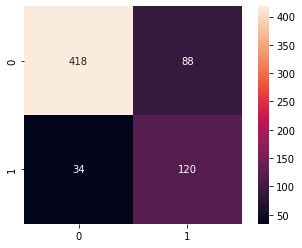

In [61]:
print_scores(pipeline, y_test, X_test)

              precision    recall  f1-score   support

  irrelevant       0.90      0.90      0.90       452
    relevant       0.79      0.79      0.79       208

    accuracy                           0.87       660
   macro avg       0.85      0.85      0.85       660
weighted avg       0.87      0.87      0.87       660

Log Loss: 0.33273


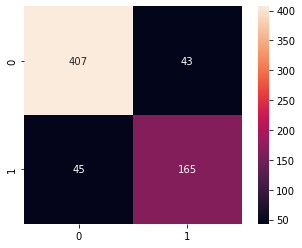

In [58]:
print_scores(best_model, y_test, X_test)

### Sanity Check

In [59]:
data['ml_tag'] = best_model.predict(data['text'])

In [60]:
data

,tweet_id,text,tag,ml_tag
0,1297680994309419008,City coyote out for an afternoon stroll in Bue...,1.0,1.0
1,252225014462558208,"At Mission Trails, This Land is Your Land! -Sc...",0.0,0.0
2,1261350788825182208,See? This that ish I’m talking about. What am ...,1.0,1.0
3,843862456502046725,"#BorregoInSpringtime @ Coyote Canyon, Anza-Bor...",0.0,0.0
4,430034569015070720,Man it is wet! (@ Coyote Valley Sporting Clays...,0.0,0.0
...,...,...,...,...
975,841179184508559360,coyotes are eating my neighbors dogs rn and id...,1.0,1.0
976,317629294505508864,I just saw two two coyotes,1.0,1.0
977,1129598475014774784,@sydneypdaniel @thundercrat I’m sure Billie wo...,1.0,1.0
978,651092067058327552,It's Monday! Let's do this! #Charity #Golf #Fo...,0.0,0.0


# Save baseline model

In [61]:
# joblib.dump(best_model, '../../../models/baseline_cvsvm.pkl')

['../../../models/baseline_cvsvm.pkl']

In [85]:
m = joblib.load('../../../models/baseline_cvsvm.pkl')

In [86]:
m.predict(['I saw a coyote across the street at the restaurant blah blah blah', 'blah blah blah'])

array([1., 0.])

# Proxy-label

# Subtract seen data from unseen data

In [72]:
all_data = pd.read_parquet('data/all_tweets.gzip')
all_data.head()
all_data = all_data[all_data['tweet_id'].notnull()]
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45498 entries, 39 to 48593
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   grid_id     45498 non-null  int64         
 1   tweet_id    45498 non-null  object        
 2   created_at  45498 non-null  datetime64[ns]
 3   text        45498 non-null  object        
 4   author_id   45498 non-null  object        
 5   place_id    42497 non-null  object        
 6   lat         24474 non-null  float64       
 7   long        24474 non-null  float64       
 8   full_name   42492 non-null  object        
 9   name        42492 non-null  object        
 10  place_type  42492 non-null  object        
 11  id          45498 non-null  int64         
 12  county      45498 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(8)
memory usage: 4.9+ MB


In [73]:
all_data.to_parquet('data/all_tweets_notnull.gzip')

In [74]:
# Tweets used to train model
data.head()

,tweet_id,text,tag,ml_tag
0,1297680994309419008,City coyote out for an afternoon stroll in Bue...,1.0,1.0
1,252225014462558208,"At Mission Trails, This Land is Your Land! -Sc...",0.0,0.0
2,1261350788825182208,See? This that ish I’m talking about. What am ...,1.0,1.0
3,843862456502046725,"#BorregoInSpringtime @ Coyote Canyon, Anza-Bor...",0.0,0.0
4,430034569015070720,Man it is wet! (@ Coyote Valley Sporting Clays...,0.0,0.0


In [76]:
seen_ids = data['tweet_id']
unseen_data = all_data[~all_data['tweet_id'].isin(seen_ids)]
unseen_data

,grid_id,tweet_id,created_at,text,author_id,place_id,lat,long,full_name,name,place_type,id,county
39,40,820841383099437058,2017-01-16 03:53:30,Back of the camera preview from today at the r...,231610931,fbd6d2f5a4e4a15e,-121.697000,41.948800,"California, USA",California,admin,40,SISKIYOU
66,67,310585251560841216,2013-03-10 02:57:49,@phoenixcoyotes. Nicccce starting the 3rd with...,69728061,fbd6d2f5a4e4a15e,-122.581384,41.805792,"California, USA",California,admin,67,SISKIYOU
72,73,19057484971,2010-07-21 06:52:06,And now I hear coyotes... they better not hurt...,54453264,ca06c9bd1e591f53,NaN,NaN,"Butte Valley, CA",Butte Valley,city,73,SISKIYOU
100,101,1115718553406033921,2019-04-09 20:50:06,@almostjingo Not to mention American citizens ...,823970107,e057ac551ce5df02,NaN,NaN,"Yreka, CA",Yreka,city,101,SISKIYOU
101,101,364985527600033795,2013-08-07 05:45:05,Goal for tomorrow is to rope a coyote #gottah...,266238333,e057ac551ce5df02,-122.611145,41.742534,"Yreka, CA",Yreka,city,101,SISKIYOU
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48588,4085,185202748202033152,2012-03-29 03:12:30,Who runs with dogs this late?? Coyotes Still...,375866895,28ace6b8d6dbc3af,-116.945490,32.643177,"Chula Vista, CA",Chula Vista,city,4085,SAN DIEGO
48589,4086,1195116824913776640,2019-11-14 23:10:29,"In the 90s, when border enforcement was still ...",15118889,07d9d3592f487000,NaN,NaN,Otay Mountain Truck Trail,Otay Mountain Truck Trail,poi,4086,SAN DIEGO
48591,4088,699642589348306945,2016-02-16 17:12:46,One of my favorite short #roadbike rides with ...,236074117,fbd6d2f5a4e4a15e,-116.612000,32.604700,"California, USA",California,admin,4088,SAN DIEGO
48592,4088,1149699890500591616,2019-07-12 15:19:48,Molly in her coyote vest decided she wanted to...,167237995,fbd6d2f5a4e4a15e,-116.592854,32.612469,"California, USA",California,admin,4088,SAN DIEGO


### Isolate tweet_id and text

In [77]:
df = unseen_data[['tweet_id', 'text']]
df.head()

,tweet_id,text
39,820841383099437058,Back of the camera preview from today at the r...
66,310585251560841216,@phoenixcoyotes. Nicccce starting the 3rd with...
72,19057484971,And now I hear coyotes... they better not hurt...
100,1115718553406033921,@almostjingo Not to mention American citizens ...
101,364985527600033795,Goal for tomorrow is to rope a coyote #gottah...


In [92]:
%%time
df['ml_tag'] = m.predict(df['text'])

Predicting Probability


ValueError: Wrong number of items passed 2, placement implies 1

In [94]:
df['ml_tag_proba'] = m.predict_proba(df['text'])[:, 1]

In [95]:
df

,tweet_id,text,ml_tag,ml_tag_proba
39,820841383099437058,Back of the camera preview from today at the r...,1.0,0.633089
66,310585251560841216,@phoenixcoyotes. Nicccce starting the 3rd with...,0.0,0.159154
72,19057484971,And now I hear coyotes... they better not hurt...,1.0,0.976598
100,1115718553406033921,@almostjingo Not to mention American citizens ...,0.0,0.415359
101,364985527600033795,Goal for tomorrow is to rope a coyote #gottah...,0.0,0.172808
...,...,...,...,...
48588,185202748202033152,Who runs with dogs this late?? Coyotes Still...,1.0,0.822305
48589,1195116824913776640,"In the 90s, when border enforcement was still ...",0.0,0.100333
48591,699642589348306945,One of my favorite short #roadbike rides with ...,0.0,0.095008
48592,1149699890500591616,Molly in her coyote vest decided she wanted to...,1.0,0.461775


In [108]:
confident_preds = df[(df['ml_tag_proba'] >= 0.90) | (df['ml_tag_proba'] <= 0.05)]

In [109]:
confident_preds

,tweet_id,text,ml_tag,ml_tag_proba
72,19057484971,And now I hear coyotes... they better not hurt...,1.0,0.976598
102,1397357765811597312,@numinousstock I could potentially run into a ...,1.0,0.932333
172,1037004682906857472,@nazani14 @Dedpull_Diva We have coyotes here a...,1.0,0.999991
206,310577694448418816,@phoenixcoyotes. Great Penalty Kill by the Co...,0.0,0.038073
222,201853679563833344,Kings + Coyotes= Intense game. Score tied 2-2....,0.0,0.001576
...,...,...,...,...
48567,1015829452654178305,Especially in eastlake and bonita cause canyon...,1.0,1.000000
48568,1025602372330958850,"Kill a 6 pack of IPAs, ""Hey let's go to Coyote...",0.0,0.009406
48571,1069347682257227776,Congrats LTCC Women’s Coyotes. You are making ...,0.0,0.023182
48578,1124788810162823174,Go team Arroyo Vista Charter Middle School Vol...,0.0,0.007167


In [113]:
confident_preds[(confident_preds['ml_tag'] == 1)].sort_values('ml_tag_proba', ascending=True)

,tweet_id,text,ml_tag,ml_tag_proba
31971,866395961865650176,first LA coyote / coydog spotting with @svensk...,1.0,0.900006
15646,1180958830156320768,Just one of many reasons I adore skunks! In ...,1.0,0.900015
46371,742423391093694465,I reprt dead animals I see on fwy 2 @SDCaltran...,1.0,0.900022
19529,268775780912340995,"Poor coyote ran onto the track and got hit, sh...",1.0,0.900068
2015,1216339511740788736,"If you want to know what #DryJanuary is like,...",1.0,0.900137
...,...,...,...,...
48567,1015829452654178305,Especially in eastlake and bonita cause canyon...,1.0,1.000000
40385,1001830636057841666,"if you have a dog, cat, or any other pet PLEAS...",1.0,1.000000
41961,1331422304291614722,‼️All my Santa Ana pet owners‼️ Please be care...,1.0,1.000000
34997,1387822081203572739,"On the trail this morning, a guy on a phone wa...",1.0,1.000000


In [111]:
confident_preds[(confident_preds['ml_tag'] == 1)].shape[0] / confident_preds[(confident_preds['ml_tag'] == 0)].shape[0]

0.2255186053999356

Save data

In [100]:
# df.to_parquet('data/unseen_with_preds.gzip')